<a href="https://colab.research.google.com/github/mountechsolutions/face-mask-detection/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!rm kaggle.json

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!unzip face-mask-detection-dataset.zip

In [11]:
!rm -rf sample_data

In [ ]:
!pip install mtcnn

# Basic Imports

In [13]:
import os
import csv
import cv2
import json
import random
import pprint as pp
import matplotlib.pyplot as plt

# Preprocssing

In [14]:
BASE_DIR = 'Medical mask/Medical mask/Medical Mask'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')

In [15]:
for file in os.listdir(ANNOTATIONS_DIR):
  with open(os.path.join(ANNOTATIONS_DIR, file), 'r') as f:
    data = json.load(f)
    pp.pprint(data)
    break

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [154, 178, 432, 544],
                  'Confidence': 1,
                  'ID': 329330485172403456,
                  'classname': 'face_with_mask',
                  'isProtected': False},
                 {'Attributes': {},
                  'BoundingBox': [171, 340, 429, 541],
                  'Confidence': 1,
                  'ID': 411605424488487232,
                  'classname': 'mask_colorful',
                  'isProtected': False}],
 'FileName': '4615.png',
 'NumOfAnno': 2}


In [16]:
faces_with_mask = []
faces_without_mask = []

with open('train.csv', 'r') as f:
  data = list(csv.reader(f))
  
  faces_with_mask = list(filter(lambda x: x[5] == 'face_with_mask', data[1:]))
  faces_without_mask = list(filter(lambda x: x[5] == 'face_no_mask', data[1:]))

random.shuffle(faces_with_mask)
random.shuffle(faces_without_mask)

print(len(faces_with_mask), len(faces_without_mask))

4180 1569


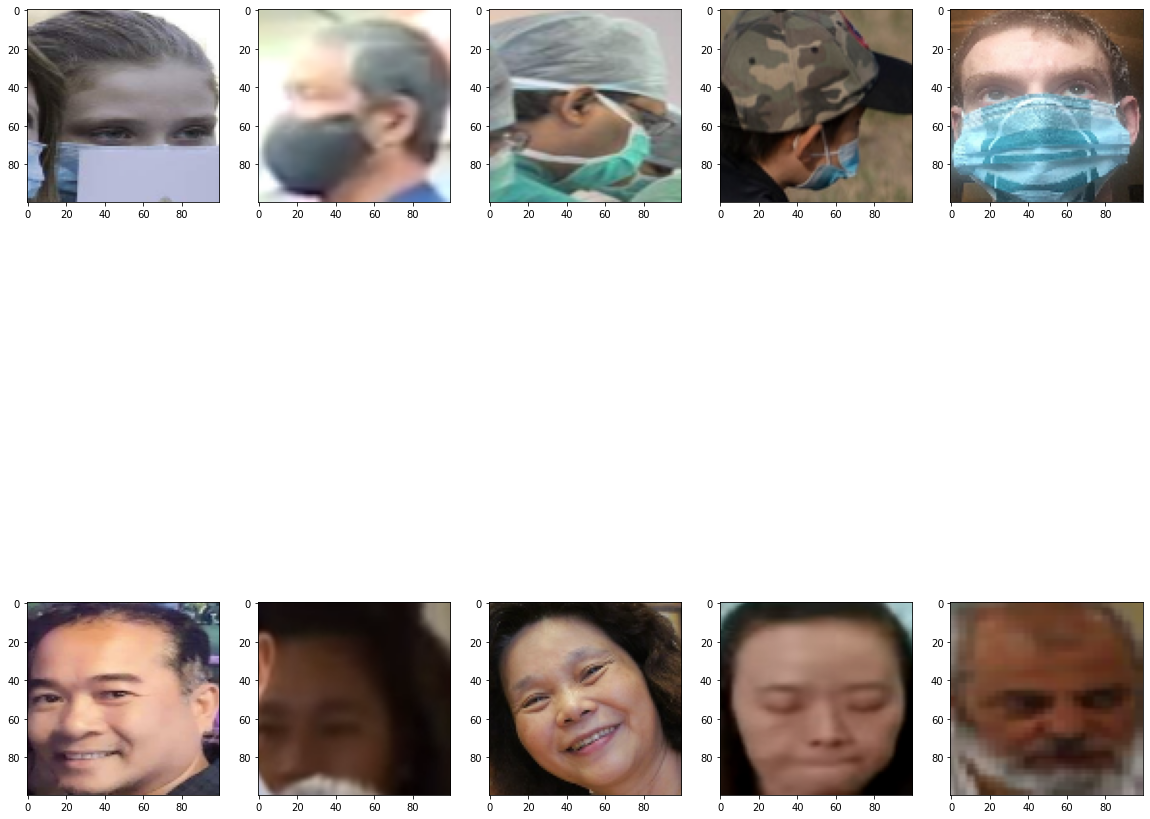

In [17]:
# Viewing data

fig, ax = plt.subplots(2, 5, figsize=(20, 20))

for i, face in enumerate(faces_with_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[0, i].imshow(image)

for i, face in enumerate(faces_without_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[1, i].imshow(image)
fig.show()

In [18]:
X = []
y = []

for i, cat in enumerate((faces_without_mask, faces_with_mask)):
  for f in cat:
    image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, f[0])), cv2.COLOR_BGR2RGB)
    start = int(f[1]), int(f[2])
    end = int(f[3]), int(f[4])
    image = image[start[1]:end[1], start[0]:end[0]]
    image = cv2.resize(image, (100, 100))
    X.append(image)
    y.append(i)

print(len(X))
print(len(y))

5749
5749


5174 575


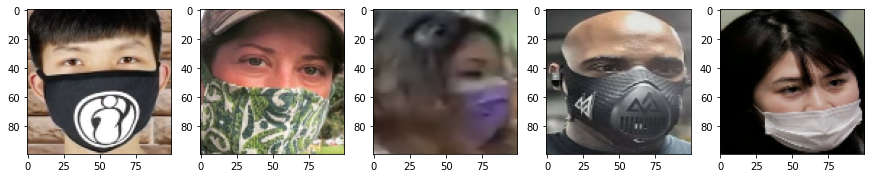

In [19]:
# Splitting the data for training and testing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# X_new = []

# for i, img in enumerate(X):
#   X_new.append(preprocess_input(img))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


print(len(X_train), len(X_test))

# Viewing trainning datas
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

for i, img in enumerate(X_train[:5]):
  ax[i].imshow(img)
fig.show()

X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train)
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test)

# Creating model architecture

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam


base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(100, 100, 3)), classes=1)

new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dense(256, activation='relu')(new_model)
new_model = Dense(1, activation='sigmoid')(new_model)

for layer in base_model.layers:
  layer.trainable = False

model = Model(inputs=base_model.input, outputs=new_model)
opt = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy' ,optimizer=opt, metrics=['accuracy'])
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

# Training

In [21]:
EPOCHS = 5

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.1)

Epoch 1/5
146/146 [==============================] - 7s 49ms/step - loss: 0.7740 - accuracy: 0.9072 - val_loss: 0.4553 - val_accuracy: 0.9305
Epoch 2/5
146/146 [==============================] - 6s 42ms/step - loss: 0.1053 - accuracy: 0.9792 - val_loss: 0.4130 - val_accuracy: 0.9440
Epoch 3/5
146/146 [==============================] - 6s 42ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.4586 - val_accuracy: 0.9459
Epoch 4/5
146/146 [==============================] - 6s 43ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.4136 - val_accuracy: 0.9517
Epoch 5/5
146/146 [==============================] - 6s 44ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.4065 - val_accuracy: 0.9479


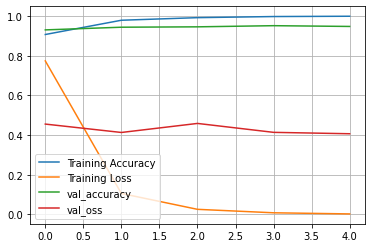

18/18 [==============================] - 1s 78ms/step - loss: 0.4208 - accuracy: 0.9357


0.9356521964073181

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_oss')
plt.grid()
plt.legend()
plt.show()

losss, acc = model.evaluate(X_test, y_test)
acc

In [23]:
model.save('model.h5')

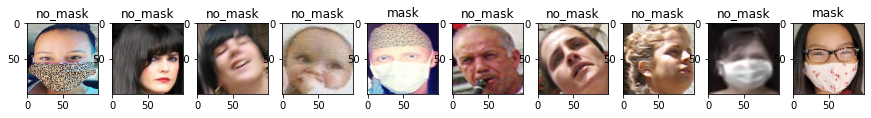

In [24]:
# from google.colab.patches import cv2_imshow
import tensorflow as tf 

cat = ('no_mask', 'mask')
fig, ax = plt.subplots(1, 10, figsize=(15, 15))

model = tf.keras.models.load_model('model.h5')

for i in range(10):
  image = random.choice(X_test)
  predictions = model.predict(image.reshape(-1, 100, 100, 3))
  title = cat[int(predictions[0][0])]

  ax[i].imshow(image.astype('uint32'))
  ax[i].title.set_text(title)

fig.show()

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def predict(model, image):
  prediction = model.predict(image.reshape(-1, 100, 100, 3))[0][0]
  return int(round(prediction, 1))

predict_array = [predict(model, image) for image in X_test]

results = confusion_matrix(y_test, predict_array)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


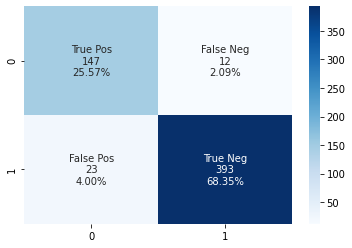

In [26]:
group_names = ["True Pos","False Neg","False Pos","True Neg"]
group_counts = ['{0:0.0f}'.format(value) for value in
                results.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(results, annot=labels, fmt='', cmap='Blues')
plt.show()